In [7]:
# %pip install numpy
# %pip install scikit-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install torch
# %pip install pylatexenc
# %pip install torchvision
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning


In [2]:
import os
os.environ["QISKIT_SUPPRESS_1_0_IMPORT_ERROR"] = "1"

In [3]:
import numpy as np
import cv2
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from monai.transforms import ScaleIntensity
import torch
from torchvision import transforms
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.neural_networks import SamplerQNN
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import kagglehub

#### Download latest version https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

In [4]:
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
# print("Path to dataset files:", path)

#### Path Definitions !!! Remove .DS_Store from folders

In [5]:
dataset_path_norm = f'{path}/chest_xray/train/NORMAL'
dataset_path_pneu = f'{path}/chest_xray/train/PNEUMONIA'
validation_path_norm = f'{path}/chest_xray/test/NORMAL'
validation_path_pneu = f'{path}/chest_xray/test/PNEUMONIA'

#### Check data

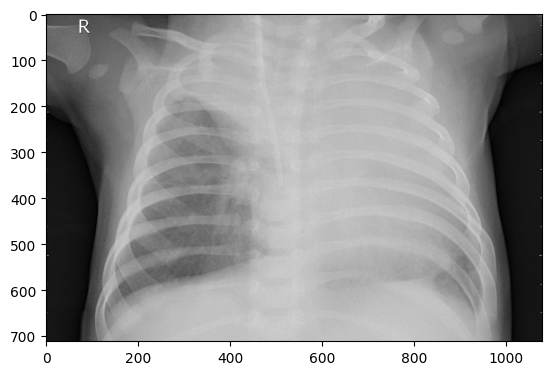

In [6]:
xray_image = cv2.imread(f'{dataset_path_pneu}/person23_bacteria_92.jpeg', cv2.IMREAD_GRAYSCALE)
plt.imshow(xray_image, cmap='gray')

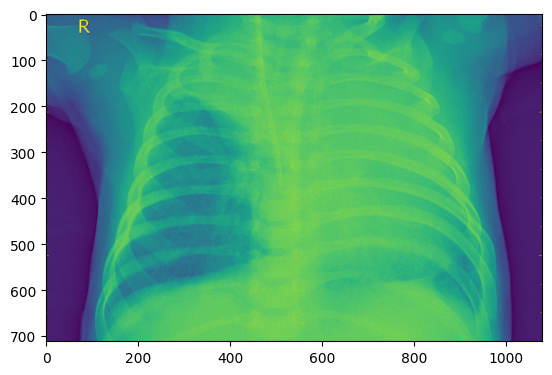

In [7]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
xray_image_scaled = transform_img(xray_image)
colored_xray = cm.viridis(xray_image_scaled)
plt.imshow(colored_xray)

#### Set image size and transformations

In [8]:
img_size = (256, 256)
transform = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def load_images_from_folder(folder, label, transform, num_samples=None):
    """Load images from folder and apply transformations, ensuring sample limit is feasible."""
    data, labels = [], []
    img_names = os.listdir(folder)
    
    # Limit the number of samples if specified, but ensure we don't sample more than available
    if num_samples and num_samples < len(img_names):
        img_names = np.random.choice(img_names, num_samples, replace=False)
    elif num_samples:
        print(f"Requested {num_samples} samples, but only {len(img_names)} available. Using all images.")
    
    for img_name in img_names:
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img = transform(img)
            img_array = img.numpy().flatten()
            data.append(img_array)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels


#### Load and limit training data for balance

In [10]:
train_data_norm, train_labels_norm = load_images_from_folder(dataset_path_norm, 0, transform, 1341)
train_data_pneu, train_labels_pneu = load_images_from_folder(dataset_path_pneu, 1, transform, 1341)

X_train = np.array(train_data_norm + train_data_pneu)
y_train = np.array(train_labels_norm + train_labels_pneu)

Requested 1341 samples, but only 1341 available. Using all images.


#### Load and limit validation data

In [11]:
test_data_norm, test_labels_norm = load_images_from_folder(validation_path_norm, 0, transform)
test_data_pneu, test_labels_pneu = load_images_from_folder(validation_path_pneu, 1, transform)

X_test = np.array(test_data_norm + test_data_pneu)
y_test = np.array(test_labels_norm + test_labels_pneu)

#### Dimensionality Reduction with PCA

In [12]:
pca = PCA(n_components=16)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

#### Convert to tensor for QNN compatibility

In [13]:
X_train_tensor = torch.tensor(X_train_pca, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

#### Compute class weights to balance classes

In [14]:
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

#### Define the Quantum Neural Network Circuit

In [15]:
def parity(x):
    return f"{bin(x)}".count("1") % 2

# Initialize QNN
num_qubits = 16
qnn_circuit = QNNCircuit(num_qubits=num_qubits)
qnn = SamplerQNN(
    circuit=qnn_circuit,
    interpret=parity,
    output_shape=2
)

#### Set random weights for testing

In [16]:
weights = np.random.rand(qnn.num_weights)

#### Forward pass with test data

In [17]:
X_test_numpy = X_test_tensor.numpy()
outputs_test = qnn.forward(input_data=X_test_numpy, weights=weights)
predictions = (outputs_test > 0.5).astype(int)

#### Calculate evaluation metrics

In [25]:
X_test_numpy = X_test_tensor.numpy()
outputs_test = qnn.forward(input_data=X_test_numpy, weights=weights)

if outputs_test.ndim > 1 and outputs_test.shape[1] > 1:
    predictions = outputs_test.argmax(axis=1)
else:
    predictions = (outputs_test > 0.5).astype(int)

y_test = y_test_tensor.numpy().astype(int)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='binary', zero_division=1)
recall = recall_score(y_test, predictions, average='binary', zero_division=1)
f1 = f1_score(y_test, predictions, average='binary', zero_division=1)
conf_matrix = confusion_matrix(y_test, predictions)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix: {conf_matrix}")

Accuracy: 0.5
Precision: 0.6258064516129033
Recall: 0.49743589743589745
F1 Score: 0.5542857142857143
Confusion Matrix: [[118 116]
 [196 194]]


#### PCA of model prediction

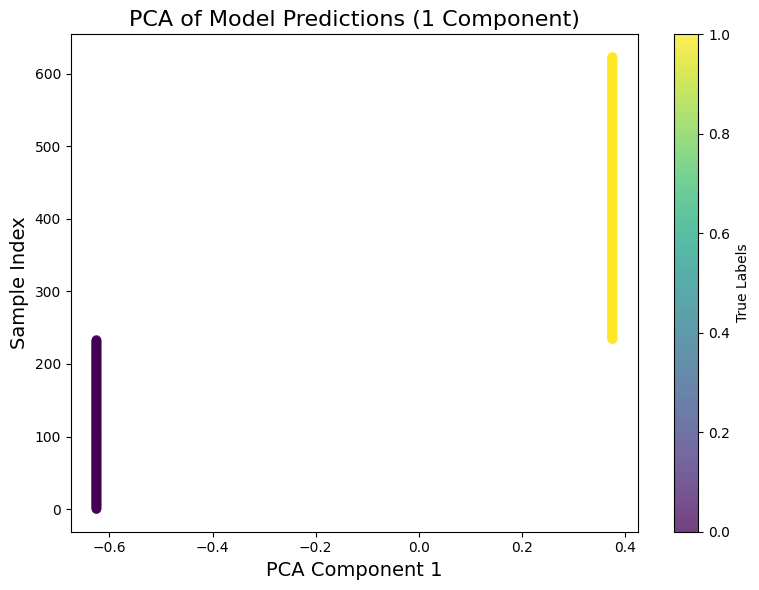

In [22]:
if y_test.ndim == 1:
    labels_test_reshaped = y_test.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

# Scatter plot: features_pca is the transformed feature, y_test_tensor holds true labels
plt.scatter(features_pca, range(len(features_pca)), c=y_test, cmap='viridis', alpha=0.75)

# Add color bar and labels
plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

#### Plotting the confusion matrix

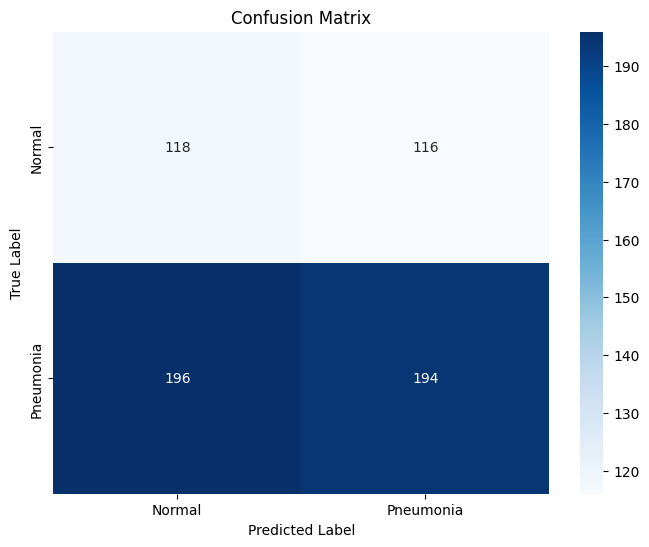

In [23]:

def plot_confusion_matrix(conf_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Pneumonia"], yticklabels=["Normal", "Pneumonia"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(conf_matrix)

In [24]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright